### Libraries & API Setup

In [2]:
# Common libraries
import matplotlib.pyplot as plt
from datetime import datetime
import requests
import json 
import pandas as pd
from utils import returns_df, plot_sector_performance

# API setup
from messari.messari import Messari                   # Messari
#m = Messari('cb0d3a33-c4c5-4b50-9fff-5dce65d44b97')   # Messari
m = Messari('f8783744-faf2-475e-8675-b3769cd55c81')   # Messari
from pycoingecko import CoinGeckoAPI                  # Coingecko
cg = CoinGeckoAPI()                                   # Coingecko
API_KEY = '27mKdxqslM3aORzuco6LoqzKjFc'               # Glassnode

### Import Data

In [3]:
cdata = pd.DataFrame(cg.get_coins_markets('usd'))

In [4]:
mdata = m.get_all_assets(asset_fields=['metrics'], to_dataframe=True)
prices = m.get_metric_timeseries(asset_universe, 'price', start, end)
asset_returns = returns_df(prices)

In [5]:
ldata = pd.DataFrame(requests.get('https://api.llama.fi/protocols').json())

### Coarse Merge

In [6]:
cdata['symbol'].str.lower()
master = cdata.merge(ldata, how = 'left', left_on = 'symbol', right_on = 'symbol')

In [7]:
master = master.merge(mdata, how = 'left', left_on = 'id_x', right_on = 'slug')

In [8]:
master.head()

,id_x,symbol,name_x,image,current_price,market_cap,market_cap_rank,fully_diluted_valuation,total_volume,high_24h,...,metrics_supply_distribution_supply_in_contracts_usd,metrics_supply_distribution_supply_in_contracts_native_units,metrics_supply_distribution_supply_shielded,metrics_supply_distribution_supply_in_top_100_addresses,metrics_supply_distribution_supply_in_top_10_percent_addresses,metrics_supply_distribution_supply_in_top_1_percent_addresses,metrics_supply_distribution_supply_in_utxo_in_loss,metrics_supply_distribution_supply_in_utxo_in_profit,metrics_alert_messages,slug_y
0,bitcoin,btc,Bitcoin,https://assets.coingecko.com/coins/images/1/la...,38986.000000,741295145416,1,8.186777e+11,2.159072e+10,40593.000,...,NaN,NaN,None,2.932434e+06,1.882346e+07,1.740021e+07,6.670937e+06,1.234360e+07,None,bitcoin
1,ethereum,eth,Ethereum,https://assets.coingecko.com/coins/images/279/...,2907.470000,350087653482,2,NaN,1.390803e+10,3077.670,...,9.424190e+10,3.145038e+07,None,4.715580e+07,1.177552e+08,1.150306e+08,NaN,NaN,None,ethereum
2,tether,usdt,Tether,https://assets.coingecko.com/coins/images/325/...,1.001000,82816485531,3,NaN,4.718871e+10,1.003,...,NaN,NaN,None,1.149024e+09,1.326209e+09,1.291699e+09,NaN,NaN,None,tether
3,binancecoin,bnb,BNB,https://assets.coingecko.com/coins/images/825/...,400.850000,67383814953,4,6.738381e+10,1.269793e+09,417.340,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,usd-coin,usdc,USD Coin,https://assets.coingecko.com/coins/images/6319...,0.997857,49903114824,5,NaN,4.158777e+09,1.006,...,1.896819e+10,1.897266e+10,None,2.706734e+10,4.406573e+10,4.228059e+10,NaN,NaN,None,usd-coin


### METRICS

##### Price Action & Returns

In [64]:
start = '2022-01-01'
end = '2022-03-31'
sector = ('ALCX', 'SPELL', 'TOKE', 'OHM', 'FXS', 'CVX')

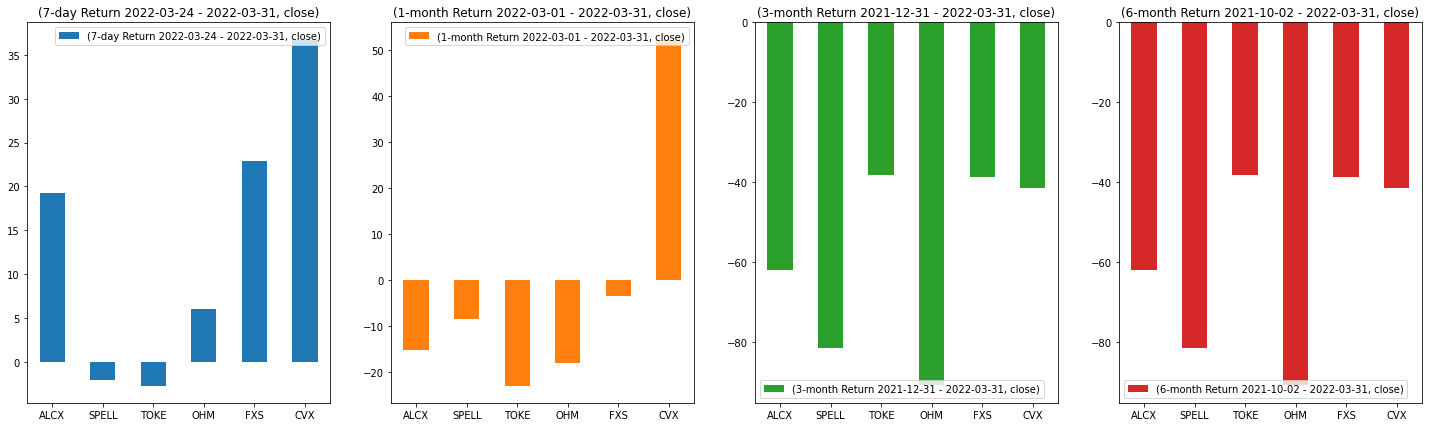

In [68]:
idx = pd.IndexSlice
sector_returns = asset_returns.loc[idx[sector, 'close'], :]
ax = sector_returns.unstack(level=1).plot(kind='bar', subplots=True, rot=0, figsize=(25, 7), layout=(1, 4))